In [6]:
import numpy as np
import pandas as pd
import arch as arch
import datetime
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [7]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [8]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.Settle.head()

Date
1990-01-02    6847.0
1990-01-03    6887.0
1990-01-04    7008.0
1990-01-05    6950.0
1990-01-08    6959.0
Name: Settle, dtype: float64

 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

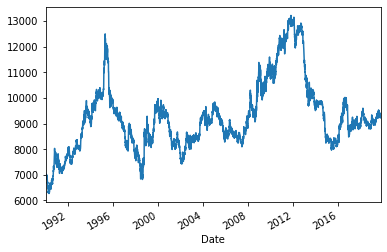

In [9]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot()


*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [10]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


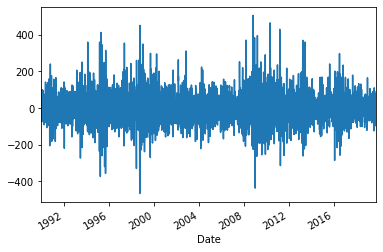

In [11]:
yen_noise.plot()

In [12]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

yen_settle = pd.DataFrame()

yen_settle = pd.concat([yen_futures['Settle'],yen_noise,yen_trend],
                       axis = "columns", join="inner")
yen_settle.columns = ["Settle","Noise","Trend"]
yen_settle.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [13]:
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


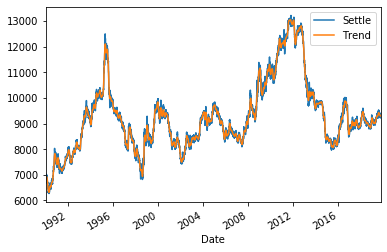

In [14]:
# Plot the Settle Price vs. the Trend
yen_settle.drop(columns = 'Noise', inplace = True)
yen_settle.plot()

In [15]:
adfuller(yen_settle.Trend.values)

(-2.457216144468759,
 0.12623405827358442,
 4,
 7510,
 {'1%': -3.4312210434835566,
  '5%': -2.861924935351738,
  '10%': -2.566974896675715},
 -30177.608869330063)

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

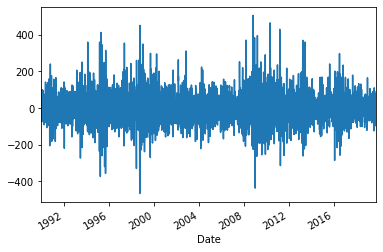

In [16]:
# Plot the Settle Noise
yen_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [17]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


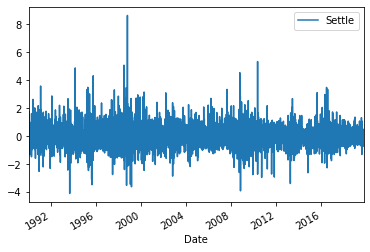

In [18]:
returns.plot()


In [19]:
returns.Settle.values

array([ 0.58419746,  1.75693335, -0.82762557, ..., -0.56430376,
        0.15133499, -0.4695089 ])

In [20]:
adfuller(returns.Settle.values)

(-87.6773623853942,
 0.0,
 0,
 7513,
 {'1%': -3.4312206955500963,
  '5%': -2.8619247816139843,
  '10%': -2.5669748148389813},
 15724.766827334091)

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# Fit the model and assign it to a variable called results
model = ARMA(returns.values, order=(2,1))
results = model.fit()



In [44]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 02 Mar 2020   AIC                          15798.142
Time:                        20:50:48   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3342           +0.0000j            3.3342            0.5000
AR.2         -157.1716           +0.0000j          157.1716            0.5000
MA.1           -3.3931           +0.0000j            3.3931            0.5000
-----------------------------------------------------------------------------
"""

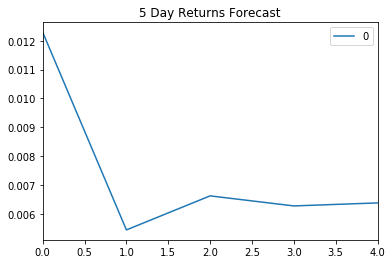

In [45]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer:

Non Staitionary isn't a good fit p value is greater then .05

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures["Settle"], order=(5,1,1))

# Fit the model
results = model.fit()

C:\Users\selprince.AGCO\AppData\Local\Continuum\anaconda3NEW\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\selprince.AGCO\AppData\Local\Continuum\anaconda3NEW\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [48]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 04 Mar 2020   AIC                          83905.238
Time:                        18:50:17   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2826      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2976      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8923           -1.3782j            2.3410           -0.1002
AR.2            1.8923           +1.3782j            2.3410            0.1002
AR.3           -2.2723           -3.0192j            3.7787           -0.3527
AR.4           -2.2723           +3.0192j            3.7787            0.3527
AR.5          -11.1469           -0.0000j           11.1469           -0.5000
MA.1            3.3599           +0.0000j            3.3599            0.0000
-----------------------------------------------------------------------------
"""

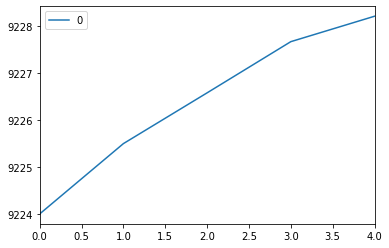

In [50]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot()

What does the model forecast will happen to the Japanese Yen in the near term?

The model expects the yen to remain fairly flat but is expected to increase slightly by 1%

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [28]:
from arch import arch_model

In [29]:
# Estimate a GARCH model:
model_2 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model_2.fit(disp="off")

In [30]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Mar 02 2020   Df Residuals:                     7510
Time:                        20:45:42   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [31]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [52]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)


In [54]:
forecasts.variance

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
1990-01-03,NaN,NaN,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN
1990-01-09,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-10-09,NaN,NaN,NaN,NaN,NaN
2019-10-10,NaN,NaN,NaN,NaN,NaN
2019-10-11,NaN,NaN,NaN,NaN,NaN


In [55]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [56]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


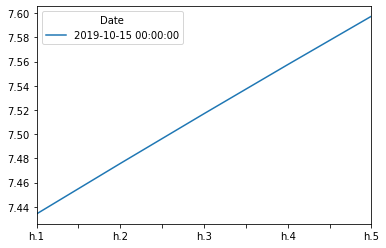

In [35]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now? The Yen is weakening against the dollar so I would not buy the yen now and I would hold on to the dollar. But there is a variance that we need to check becuase the variance is going up which means volatility is increasing.

Is the risk of the yen expected to increase or decrease? The risk that the yen will shed value against the dollar is increasing

Based on the model evaluation, would you feel confident in using these models for trading? The P-value of the model is below .05 and hence gives comfort on its reliability

